Survivors Classification on Titanic using  R
===

Wesley Nogueira Galvão 

July, 2019

# Introduction

# Question definition

# Data

## Data Dictionary

|Variable |Definition|Key|
|:---- |----|----:|
|survival  | Survival |0 = No, 1 = Yes|
|pclass |Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd|
|sex  |Sex| 	
|Age  | Age in years| 	
|sibsp| # of siblings / spouses aboard the Titanic |
|parch |# of parents / children aboard the Titanic |	
|ticket| Ticket number| 	
|fare 	|Passenger fare (British pound)| 	
|cabin 	|Cabin number| 	
|embarked |Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**Variables Notes**
- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them. 

# Strategy

# Feature Engineering

In [824]:
install.packages('corrplot')

Warning message:
“unable to access index for repository https://cran.r-project.org/src/contrib:
  não foi possível abrir a URL 'https://cran.r-project.org/src/contrib/PACKAGES'”Warning message:
“package ‘corrplot’ is not available (for R version 3.5.1)”

In [ ]:
library('ggplot2')   # visualization
library('ggthemes')  # visualization
library('scales')    # visualization
library('dplyr')     # data manipulation
library('csv')       # CVS manipulation
library('tidyr')
library('tibble')
library('janitor')
library('corrplot')   # Plot correlation matrix
library('gridExtra')  # arrange plots
library('ggpubr')
library('caret')      #confusionMatrix
library('MASS')       # Stepwise regression
library('randomForest')
library('party')     # Decision Tree
library('forecast') #Accuracy 
library('DescTools')

options(repr.plot.width=5, repr.plot.height=5) #Control the plot size


In [764]:
#Reading the datasets
train <- read.csv('Data/train.csv', stringsAsFactors = F, header=T, na.strings=c(""))
test <- read.csv('Data/test.csv', stringsAsFactors = F, header=T, na.strings=c(""))
#Bindind both parts to the same dataset
titanic_data <- bind_rows(train, test) 

In [765]:
# dataset dimension
cat(sprintf('Dataset dimension: %d rows and %d columns',dim(titanic_data)[1], dim(titanic_data)[2]))

Dataset dimension: 1309 rows and 12 columns

In [766]:
head(titanic_data, 5)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S


## New features

### Family size

In [767]:
# FamilySize feature creation
titanic_data$FamilySize <- titanic_data$SibSp + titanic_data$Parch + 1

### Alone

In [768]:
# Create a new feature Alone where if FamilySize == 1, then Alone == 1, 0 otherwise.
titanic_data$Alone[titanic_data$FamilySize == 1] <- 1
titanic_data$Alone[titanic_data$FamilySize > 1] <- 0

### Name Titles 

In [769]:
# Extract title from passenger name and add it to Title feature
titanic_data$Title <- gsub('(.*, )|(\\..*)', '', titanic_data$Name)
# Create the secondary Tittle feature
titanic_data$Title2 <- gsub('(.*, )|(\\..*)', '', titanic_data$Name)
# Summarise the title type by its proportion
title_prop <- titanic_data %>% 
 tabyl(Title) %>%
 adorn_pct_formatting(digits = 1)
title_prop

Title,n,percent
Capt,1,0.1%
Col,4,0.3%
Don,1,0.1%
Dona,1,0.1%
Dr,8,0.6%
Jonkheer,1,0.1%
Lady,1,0.1%
Major,2,0.2%
Master,61,4.7%
Miss,260,19.9%


In [770]:
# Define a variable that will receive the rare titles as a vector
rare <- c()
# Loop to store occurrences less than 10
for(i in 1:18){
    if (title_prop[i,2] < 10){
        rare[i] <- title_prop[i,1]
    } 
}
# Drop the NA ocurrences
rare <- rare  %>% na.omit()
rare

[1] "Capt"         "Col"          "Don"          "Dona"         "Dr"          
 [6] "Jonkheer"     "Lady"         "Major"        "Mlle"         "Mme"         
[11] "Ms"           "Rev"          "Sir"          "the Countess"
attr(,"na.action")
[1]  9 10 13 14
attr(,"class")
[1] "omit"

In [771]:
# Treating the first Title feature. 
titanic_data$Title[titanic_data$Title %in% rare] <- 'Rare'
titanic_data$Title[titanic_data$Title == 'Mlle'] <- 'Miss'
titanic_data$Title[titanic_data$Title == 'Ms']   <- 'Miss'
titanic_data$Title[titanic_data$Title == 'Mme']  <- 'Mrs'

In [772]:
# Treating the second Title feature
titanic_data$Title2[titanic_data$Title2 == 'Capt']         <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Col']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Don']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Dona']         <- 'Mrs'
titanic_data$Title2[titanic_data$Title2 == 'Lady']         <- 'Mrs'
titanic_data$Title2[titanic_data$Title2 == 'Major']        <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Mlle']         <- 'Miss'
titanic_data$Title2[titanic_data$Title2 == 'Mme']          <- 'Mrs'
titanic_data$Title2[titanic_data$Title2 == 'Ms']           <- 'Miss'
titanic_data$Title2[titanic_data$Title2 == 'Rev']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'Sir']          <- 'Mr'
titanic_data$Title2[titanic_data$Title2 == 'the Countess'] <- 'Mrs'

ifelse(titanic_data$Title2 == 'Dr' && titanic_data$Sex == 'male',
       titanic_data$Title2[titanic_data$Title2 == 'Dr'] <- 'Mr',
       titanic_data$Title2[titanic_data$Title2 == 'Dr'] <- 'Mrs')

ifelse(titanic_data$Title2 == 'Jonkheer' && titanic_data$Sex == 'male',
       titanic_data$Title2[titanic_data$Title2 == 'Jonkheer'] <- 'Mr',
       titanic_data$Title2[titanic_data$Title2 == 'Jonkheer'] <- 'Miss')

[1] "Mrs"

[1] "Miss"

In [773]:
# Title proportion for the first Title feature after feature engineering 
title_prop <- titanic_data %>% 
 tabyl(Title) %>%
 adorn_pct_formatting(digits = 1)
title_prop
# Title proportion for the second Title feature after feature engineering 
title_prop2 <- titanic_data %>% 
 tabyl(Title2) %>%
 adorn_pct_formatting(digits = 1)
title_prop2

Title,n,percent
Master,61,4.7%
Miss,260,19.9%
Mr,757,57.8%
Mrs,197,15.0%
Rare,34,2.6%


Title2,n,percent
Master,61,4.7%
Miss,265,20.2%
Mr,774,59.1%
Mrs,209,16.0%


### Adult 

In [774]:
# Create a new feature Adult where if passenger is adult(>= 18), then 1, 0 otherwise.
titanic_data$Adult[titanic_data$Age >= 18] <- 1
titanic_data$Adult[titanic_data$Age < 18] <- 0



### Deck

In [775]:
# Extract the first character that represents the deck and store it in Deck column
titanic_data$Deck <- substr(titanic_data$Cabin, 1, 1)

#Deck proportion by type
deck_prop <- titanic_data %>% 
 tabyl(Deck) %>%
 adorn_pct_formatting(digits = 1)
deck_prop

Deck,n,percent,valid_percent
A,22,1.7%,7.5%
B,65,5.0%,22.0%
C,94,7.2%,31.9%
D,46,3.5%,15.6%
E,41,3.1%,13.9%
F,21,1.6%,7.1%
G,5,0.4%,1.7%
T,1,0.1%,0.3%
NA,1014,77.5%,-


## Missing values

In [776]:
#Check for missing values by feature
sapply(titanic_data, function(x) sum(is.na(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1        1014           2 
 FamilySize       Alone       Title      Title2       Adult        Deck 
          0           0           0           0         263        1014

### Missing values of Age

In [777]:
summary(titanic_data$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.88   39.00   80.00     263 

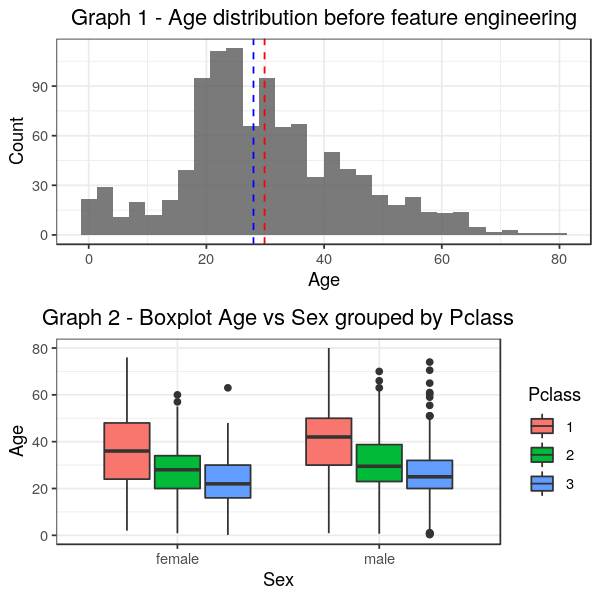

In [778]:
g1 <- titanic_data %>%
    ggplot() + 
    geom_histogram(aes(Age), na.rm = T,alpha= 0.8, bins = 30) +
    geom_vline(aes(xintercept = mean(Age, na.rm = T)),
               color = "red", linetype = "dashed", size =.5) +
    geom_vline(aes(xintercept = median(Age, na.rm = T)),
               color = "blue", linetype = "dashed", size =.5) +
    labs(x = "Age", y = "Count") +  theme_bw() +  
    ggtitle('Graph 1 - Age distribution before feature engineering') +
    theme(plot.title = element_text(hjust = 0.5))   

g2 <- titanic_data %>%
    ggplot() +
    geom_boxplot(aes(x = Sex, y = Age, fill = as.factor(Pclass)),na.rm = T) +
    labs(x = 'Sex', y = 'Age') + 
    scale_fill_discrete(name = "Pclass") + theme_bw() +     
    ggtitle('Graph 2 - Boxplot Age vs Sex grouped by Pclass') + 
    theme(plot.title = element_text(hjust = 0.5)) 


ggarrange(g1, g2, nrow = 2)


In [779]:
#Calculate the median grouped by the Pclass and Sex = male
Mgroup1 <- titanic_data %>% filter(Pclass == 1, Sex == 'male')
Mmedian1 <- median(Mgroup1$Age,na.rm = T)

Mgroup2 <- titanic_data %>% filter(Pclass == 2, Sex == 'male') 
Mmedian2 <- median(Mgroup2$Age,na.rm = T)

Mgroup3 <- titanic_data %>% filter(Pclass == 3, Sex == 'male') 
Mmedian3 <- median(Mgroup3$Age,na.rm = T)



In [780]:
#Calculate the median grouped by the Pclass and Sex = female
Fgroup1 <- titanic_data %>% filter(Pclass == 1, Sex == 'female')
Fmedian1 <- median(Fgroup1$Age,na.rm = T)

Fgroup2 <- titanic_data %>% filter(Pclass == 2, Sex == 'female') 
Fmedian2 <-median(Fgroup2$Age,na.rm = T)

Fgroup3 <- titanic_data %>% filter(Pclass == 3, Sex == 'female') 
Fmedian3 <-median(Fgroup3$Age,na.rm = T)


In [781]:
# Fill the Age's NULL values with median of respective group 
for(i in 1:dim(titanic_data)[1]){
    if(titanic_data$Sex[i] == 'male' && is.na(titanic_data$Age[i])){
        if(titanic_data$Pclass[i] == 1)
            titanic_data$Age[i] <-  Mmedian1
        if(titanic_data$Pclass[i] == 2)
             titanic_data$Age[i] <- Mmedian2
        if(titanic_data$Pclass[i] == 3)
             titanic_data$Age[i] <- Mmedian3
    }
     if(titanic_data$Sex[i] == 'female' && is.na(titanic_data$Age[i])){
        if(titanic_data$Pclass[i] == 1)
            titanic_data$Age[i] <-  Fmedian1
        if(titanic_data$Pclass[i] == 2)
             titanic_data$Age[i] <- Fmedian2
        if(titanic_data$Pclass[i] == 3)
             titanic_data$Age[i] <- Fmedian3
    }
}


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.17   22.00   26.00   29.26   36.00   80.00 

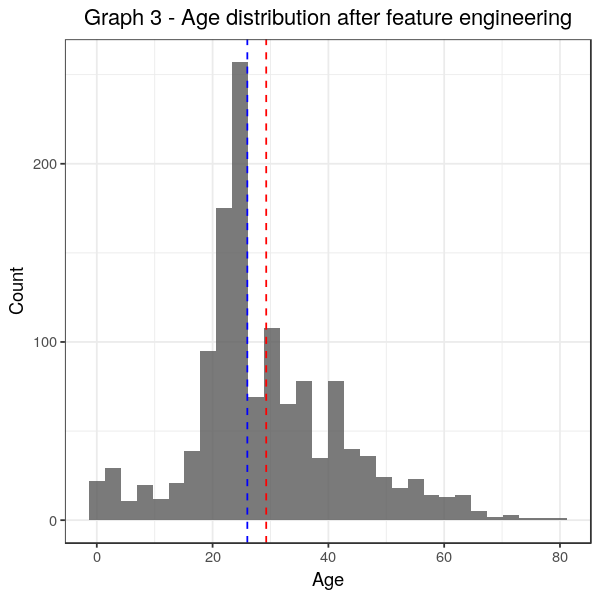

In [782]:
# Show Age summary
summary(titanic_data$Age)

# Plot age distribution
g3 <- titanic_data %>%
    ggplot() + 
    geom_histogram(aes(Age),alpha= 0.8, bins = 30) +
    geom_vline(aes(xintercept = mean(Age, na.rm = T)),
               color = "red", linetype = "dashed", size =.5) +
    geom_vline(aes(xintercept = median(Age, na.rm = T)),
               color = "blue", linetype = "dashed", size =.5) +
    labs(x = "Age", y = "Count") +  theme_bw() +  
    ggtitle('Graph 3 - Age distribution after feature engineering') +
    theme(plot.title = element_text(hjust = 0.5))   
g3



### Missing values of Adult

In [783]:
# Fill the missing values with the same condition of Adult feature
titanic_data$Adult[titanic_data$Age >= 18] <- 1
titanic_data$Adult[titanic_data$Age < 18 ]<- 0

### Missing values of Fare

In [784]:
# Get the position(passenger ID) where Fare's value is NULL.  
id_fare_na <- which(is.na(titanic_data$Fare))
id_fare_na

[1] 1044

In [785]:
titanic_data[id_fare_na,(3:12)]


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,NA,S


In [786]:
# Get the mean and median to Pclass 3 and Embarked S
fare_summary_3S <- titanic_data  %>% 
    filter(Embarked == 'S', Pclass == 3)  %>% 
    summarise("Mean" = mean(Fare, na.rm = T), "Median" = median(Fare, na.rm = T))

fare_summary_3S

Mean,Median
14.43542,8.05


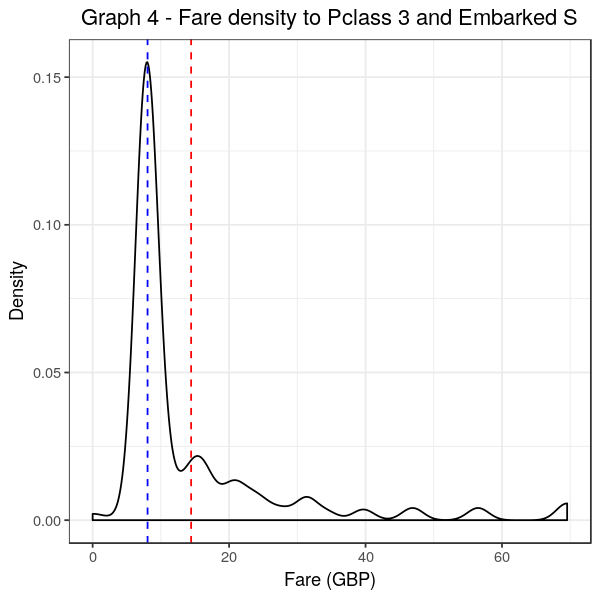

In [787]:
# Plot fare density to Pclass 3 and Embarked S
g4 <- titanic_data[titanic_data$Pclass == '3' & titanic_data$Embarked == 'S',] %>%
    ggplot() + 
    geom_density(aes(Fare), na.rm = T) +
    geom_vline(aes(xintercept = mean(Fare, na.rm = T)),
               color = "red", linetype = "dashed", size =.5) +
    geom_vline(aes(xintercept = median(Fare, na.rm = T)),
               color = "blue", linetype = "dashed", size =.5) +
    labs(x = "Fare (GBP)", y = "Density") +  theme_bw() +  
    ggtitle('Graph 4 - Fare density to Pclass 3 and Embarked S') +
    theme(plot.title = element_text(hjust = 0.5))   
g4


In [788]:
# Replace the missing value with the already calculated median for Pclass 3 and Embarked S
fare_median_3S <- fare_summary_3S[1,2]
titanic_data$Fare[1044] <- fare_median_3S

###  Missing values of Embarked

In [789]:
# Get the position(passenger ID) where Embarked's value is NULL.  
ids_embarked_na <- which(is.na(titanic_data$Embarked))
ids_embarked_na
titanic_data[ids_embarked_na, (3:12)]

[1]  62 830

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
62,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NA
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NA


In [790]:
# Get the mean and median to Pclass 3 and Embarked S
embarked_summary_1 <- titanic_data  %>% 
    filter(Pclass == 1)  %>%
    group_by(Embarked)  %>%
    #na.omit() %>% 
    summarise("Mean" = mean(Fare, na.rm = T), 
              "Median" = median(Fare, na.rm = T))

embarked_summary_1

Embarked,Mean,Median
C,106.84533,76.7292
Q,90.00000,90.0000
S,72.14809,52.0000
NA,80.00000,80.0000


In [791]:
## Replace the missing values with Embarked == 'C'
titanic_data$Embarked[ids_embarked_na] <- 'C'

### Missing values of Deck

In [792]:
# Get the Deck frequency by Pclass 1
deck_summary_1 <- titanic_data  %>% 
    filter(Pclass == 1)  %>%
    group_by(Deck)  %>%
    summarise("Deck Frequency" = n(), "Fare mean" = mean(Fare), "Fare median" = median(Fare))
deck_summary_1


Deck,Deck Frequency,Fare mean,Fare median
A,22,41.24431,35.0771
B,65,122.38308,82.2667
C,94,107.92660,86.2896
D,40,58.91907,53.1000
E,34,63.46471,55.4417
T,1,35.50000,35.5000
NA,67,70.26816,39.6000


In [793]:
# Replace the Deck missing values with the Deck with the most occuring value
for(i in 1:dim(titanic_data)[1]){
    if(is.na(titanic_data$Deck[i]) && titanic_data$Pclass[i] == 1){
        if(titanic_data$Fare[i] >= 0 && titanic_data$Fare[i] < 35.0771)
            titanic_data$Deck[i] <- 'A'
        if(titanic_data$Fare[i] >= 35.0771 && titanic_data$Fare[i] < 35.5000)
            titanic_data$Deck[i] <- 'T'
        if(titanic_data$Fare[i] >= 35.5000 && titanic_data$Fare[i] < 53.1000)
            titanic_data$Deck[i] <- 'D'
        if(titanic_data$Fare[i] >= 53.1000 && titanic_data$Fare[i] < 55.4417)
            titanic_data$Deck[i] <- 'E'
        if(titanic_data$Fare[i] >= 55.4417 && titanic_data$Fare[i] < 82.2667)
            titanic_data$Deck[i] <- 'B'
        if(titanic_data$Fare[i] >= 82.2667 )
            titanic_data$Deck[i] <- 'C'
    }
}

In [794]:
# Get the Deck frequency by Pclass 2
deck_summary_2 <- titanic_data  %>% 
    filter(Pclass == 2)  %>%
    group_by(Deck)  %>%
    summarise("Deck Frequency" = n(), "Fare mean" = mean(Fare), "Fare median" = median(Fare))
deck_summary_2

Deck,Deck Frequency,Fare mean,Fare median
D,6,13.59583,13.39585
E,4,11.58750,11.42500
F,13,23.42308,26.00000
NA,254,21.39454,15.66460


In [795]:
# Replace the Deck missing values with the Deck with the most occuring value
for(i in 1:dim(titanic_data)[1]){
    if(is.na(titanic_data$Deck[i]) && titanic_data$Pclass[i] == 2){
        if(titanic_data$Fare[i] >= 0 && titanic_data$Fare[i] < 11.42500)
            titanic_data$Deck[i] <- 'E'
        if(titanic_data$Fare[i] >= 11.42500 && titanic_data$Fare[i] < 13.39585)
            titanic_data$Deck[i] <- 'D'
        if(titanic_data$Fare[i] >= 13.39585)
            titanic_data$Deck[i] <- 'F'
    }
}

In [796]:
# Get the Deck frequency by Pclass 3
deck_summary_3 <- titanic_data  %>% 
    filter(Pclass == 3)  %>%
    group_by(Deck)  %>%
    summarise("Deck Frequency" = n(), "Fare mean" = mean(Fare), "Fare median" = median(Fare))
deck_summary_3

Deck,Deck Frequency,Fare mean,Fare median
E,3,11.000000,12.475
F,8,9.395838,7.650
G,5,14.205000,16.700
NA,693,13.343872,8.050


In [797]:
# Replace the Deck missing values with the Deck with the most occuring value
for(i in 1:dim(titanic_data)[1]){
    if(is.na(titanic_data$Deck[i]) && titanic_data$Pclass[i] == 3){
        if(titanic_data$Fare[i] >= 0 && titanic_data$Fare[i] < 7.650)
            titanic_data$Deck[i] <- 'F'
        if(titanic_data$Fare[i] >= 7.650  && titanic_data$Fare[i] < 12.475)
            titanic_data$Deck[i] <- 'E'
        if(titanic_data$Fare[i] >= 12.475)
            titanic_data$Deck[i] <- 'G'
    }
}

### Age X PClass


In [798]:
titanic_data$AgePclass <- titanic_data$Age*titanic_data$Pclass

### Pclass X Family Size

In [799]:
titanic_data$FareFsize <- titanic_data$Fare*titanic_data$FamilySize

In [800]:
#Check for missing values by feature
sapply(titanic_data, function(x) sum(is.na(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           0 
 FamilySize       Alone       Title      Title2       Adult        Deck 
          0           0           0           0           0           0 
  AgePclass   FareFsize 
          0           0

# Exploratory data analysis

## Data summary

In [801]:
titanic_data %>% 
 tabyl(Sex) %>%
 adorn_pct_formatting(digits = 1)

Sex,n,percent
female,466,35.6%
male,843,64.4%


In [802]:
# Write the solution to file
write.csv(titanic_data, file = 'Data/full.csv', row.names = F)

# Model and Prediction

In [803]:
# Create a subset with only the insteresting features
titanic_data_sub <- subset(titanic_data, select = c(2,3,5,6,10,12,13,14,16,17,19,20))


# Convert the categorical features to factor
titanic_data_sub$Survived <- as.factor(titanic_data_sub$Survived)
titanic_data_sub$Pclass <- as.factor(titanic_data_sub$Pclass)
titanic_data_sub$Sex <- as.factor(titanic_data_sub$Sex)
titanic_data_sub$Embarked <- as.factor(titanic_data_sub$Embarked)
titanic_data_sub$Alone <- as.factor(titanic_data_sub$Alone)
titanic_data_sub$Title2 <- as.factor(titanic_data_sub$Title2)
titanic_data_sub$Adult <- as.factor(titanic_data_sub$Adult)

# Show the chosen features
head(titanic_data_sub,3)

Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Alone,Title2,Adult,AgePclass,FareFsize
0,3,male,22,7.2500,S,2,0,Mr,1,66,14.5000
1,1,female,38,71.2833,C,2,0,Mrs,1,38,142.5666
1,3,female,26,7.9250,S,1,1,Miss,1,78,7.9250


In [804]:
# Split the subset into a train and a test subset
train2 <- titanic_data_sub[1:891,]
test2 <- titanic_data_sub[892:1309,]

## Logistic Regression

In [851]:
# Create a fitted model
fitted_model <- glm(Survived ~.,family=binomial(link='logit'), data=train2)
fitted_model2 <- glm(Survived~Sex+Title2+AgePclass+FareFsize,family=binomial(link='logit'), data=train2)
summary(fitted_model)



Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3972  -0.5585  -0.3882   0.5238   2.4309  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  9.136e+00  1.386e+00   6.592 4.34e-11 ***
Pclass2     -1.273e+00  5.634e-01  -2.260  0.02381 *  
Pclass3     -2.455e+00  7.991e-01  -3.072  0.00212 ** 
Sexmale     -3.690e+00  9.355e-01  -3.944 8.00e-05 ***
Age         -3.315e-02  2.266e-02  -1.463  0.14343    
Fare         2.918e-03  3.991e-03   0.731  0.46471    
EmbarkedQ   -7.684e-02  3.994e-01  -0.192  0.84743    
EmbarkedS   -3.682e-01  2.560e-01  -1.438  0.15041    
FamilySize  -5.625e-01  1.363e-01  -4.126 3.69e-05 ***
Alone1      -3.478e-01  3.145e-01  -1.106  0.26870    
Title2Miss  -4.140e+00  1.082e+00  -3.827  0.00013 ***
Title2Mr    -3.342e+00  5.688e-01  -5.877 4.19e-09 ***
Title2Mrs   -3.318e+00  1.051e+00  -3.157  0.00160 ** 
Adult1     

### Stepwise regression - Backward approach

In [806]:
# Perform a stepwise regression with Backwards elimination approach to find the parsimonious model
backward_model1 <- stepAIC(fitted_model, direction = "backward", 
                      trace = FALSE)
summary(backward_model1)


Call:
glm(formula = Survived ~ Pclass + Sex + Age + Fare + FamilySize + 
    Title2, family = binomial(link = "logit"), data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4688  -0.5542  -0.3798   0.5350   2.5523  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  8.501811   1.210620   7.023 2.18e-12 ***
Pclass2     -1.278135   0.326857  -3.910 9.22e-05 ***
Pclass3     -2.336165   0.326826  -7.148 8.80e-13 ***
Sexmale     -3.768687   0.916607  -4.112 3.93e-05 ***
Age         -0.032267   0.009595  -3.363 0.000771 ***
Fare         0.003936   0.002601   1.513 0.130258    
FamilySize  -0.487562   0.084078  -5.799 6.67e-09 ***
Title2Miss  -4.243558   1.049906  -4.042 5.30e-05 ***
Title2Mr    -3.436904   0.521441  -6.591 4.36e-11 ***
Title2Mrs   -3.342468   1.016654  -3.288 0.001010 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null devian

### Prediction

In [855]:
# Prediction
fitted.results <- predict(fitted_model,newdata=subset(test2,type='response'))
fitted.results <- ifelse(fitted.results > 0.5,1,0)

solution <- data.frame(PassengerID = test$PassengerId, Survived = fitted.results)


In [856]:
gender_submission <- read.csv('Data/gender_submission.csv', stringsAsFactors = F, header=T, na.strings=c(""))
gender_submission$Survived <- as.factor(gender_submission$Survived)
solution$Survived <- as.factor(solution$Survived)
#Accuracy
misClasificError <- mean(solution$Survived != gender_submission$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.909090909090909"


In [854]:
# Write the solution to file
write.csv(solution, file = 'Data/Solution_LogisticRegression.csv', row.names = F)

## Random Forest

In [858]:
# Use the already parsimonious formula to fit a random forest model
#randomForest_model <- randomForest(formula(backward_model1), data = train2)
randomForest_model <- randomForest(Survived ~., data = train2)

# Get importance
importance    <- importance(randomForest_model)
varImportance <- data.frame(Features = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))


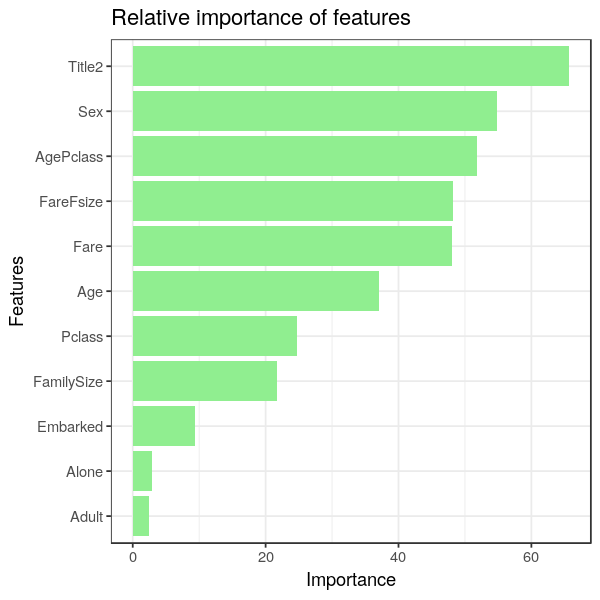

In [859]:
# Plot relative importance of variables from formula
varImportance %>% 
  ggplot(aes(x = reorder(Features, Importance), y = Importance)) + 
  geom_bar(stat = "identity", fill = 'lightgreen') +
  theme(text = element_text(size = 10)) +   
  theme(axis.text.x = element_text( hjust = 1, vjust = 0.5)) +
  labs(x='Features', y='Importance') +
  ggtitle('Relative importance of features') +
  coord_flip() + theme_bw()
  

In [860]:
# Predict using the test set
prediction <- predict(randomForest_model, test2)

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution_rf <- data.frame(PassengerID = test$PassengerId, Survived = prediction)

misClasificError <- mean(solution_rf$Survived != gender_submission$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.868421052631579"


In [862]:
# Write the solution to file
write.csv(solution_rf, file = 'Data/Solution_randomForest.csv', row.names = F)

## Decision Tree



In [272]:
output.tree <- ctree(backward_model1, data = train2)
rpred <- predict(output.tree, newdata=test2)

# References